# Pitch recognition from speech
Feature extraction using **pretrained audio processor** on raw audio files
<br> Train baseline LogReg model
<br> Train SVM model


In [28]:
import random
import glob
import os
from pathlib import Path
import matplotlib.pyplot as plt
from IPython.display import Audio
import pickle
from tqdm import tqdm

import librosa
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from transformers import Wav2Vec2Processor, Wav2Vec2Model
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import random_split
import torch.optim as optim
import joblib

from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Loading and Visualizing random Audio File

In [3]:
# QC
dataset_dir = r"C:\Users\USER\Documents\...\Statements, Questions, and Exclamations\Wave"
all_files = list(Path(dataset_dir).rglob("*.wav"))
print(len(all_files))  # raw count

12660


In [4]:
# play audio file
dataset_dir = r"C:\Users\USER\Documents\...\Statements, Questions, and Exclamations"
datatype = "Wave"
targets = ["Statements", "Questions", "Exclamations"]
target = random.choice(targets)
person = str(random.randint(1, 10)) 
person_dir = os.path.join(dataset_dir, datatype, target, person)

wav_files = [f for f in os.listdir(person_dir) if f.lower().endswith(".wav")]
wav_file = random.choice(wav_files)
print(target, wav_file)
wav_path = os.path.join(person_dir, wav_file)

audio_signal, sample_rate = librosa.load(wav_path, sr=None)
Audio(wav_path)

Questions 6QF004.wav


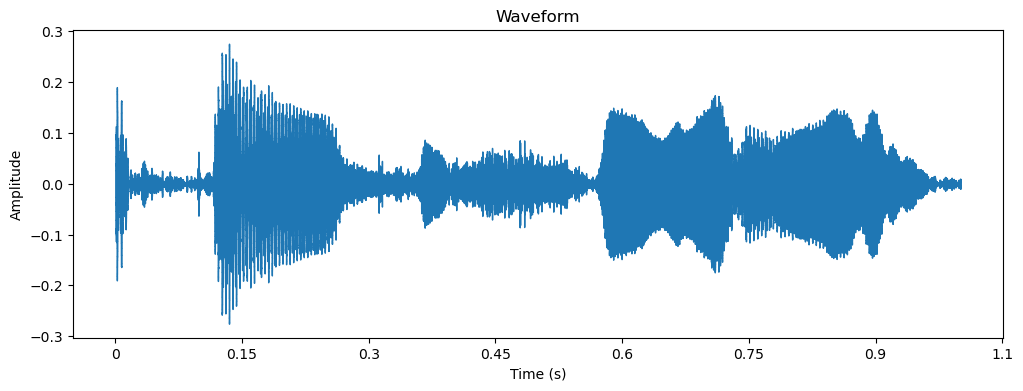

In [5]:
plt.figure(figsize=(12, 4))
librosa.display.waveshow(audio_signal, sr=sample_rate)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

## Read audio signals for feature extraction

In [6]:
# QC
# 12660
dataset_dir = r"C:\Users\USER\Documents\...\Statements, Questions, and Exclamations\Raw Data"
all_files = list(Path(dataset_dir).rglob("*.ogg"))
print(len(all_files))  # raw count

12660


In [7]:
class AudioDataset(Dataset):
    '''
    Dataset wrapper for raw .ogg files
    '''
    def __init__(self, dataset_dir, targets, sr=16000):
        self.samples = []
        self.labels = []
        self.fnames = []
        self.sr = sr

        for label, target in enumerate(targets):
            target_dir = os.path.join(dataset_dir, target)
            for root, _, files in os.walk(target_dir):
                for fname in files:
                    if not fname.endswith(".ogg"):
                        continue
                    fpath = os.path.join(root, fname)
                    self.samples.append(fpath)
                    self.labels.append(label)
                    self.fnames.append(fname)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        fpath = self.samples[idx]
        y, sr = librosa.load(fpath, sr=self.sr)
        return torch.tensor(y, dtype=torch.float32), self.labels[idx], self.fnames[idx]



In [8]:
# Load pretrained Wav2Vec2
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
wav2vec_model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")
wav2vec_model.eval()

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wav2Vec2Model(
  (feature_extractor): Wav2Vec2FeatureEncoder(
    (conv_layers): ModuleList(
      (0): Wav2Vec2GroupNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (activation): GELUActivation()
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
      )
      (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
    )
  )
  (feature_projection): Wav2Vec2FeatureProjection(
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=512, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Wav2Vec2Encoder(
    (pos_conv_embed): Wav2Vec2PositionalConvEmbedding(
  

In [9]:
%%time
dataset_dir = r"C:\Users\USER\Documents\...\Statements, Questions, and Exclamations\Raw Data"
targets = ["Statements", "Questions", "Exclamations"]

dataset = AudioDataset(dataset_dir, targets, sr=16000)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)  # batch_size=1 since wav lengths vary

all_embeddings, all_labels, all_files = [], [], []

# Extract embeddings using pretrained transformers
with torch.no_grad():
    for batch_wav, batch_y, batch_fnames in tqdm(dataloader, desc="Extracting Wav2Vec2 embeddings"):
        inputs = processor(batch_wav.squeeze().numpy(), return_tensors="pt", sampling_rate=16000, padding=True)
        outputs = wav2vec_model(**inputs).last_hidden_state  # shape: (1, seq_len, hidden_dim)

        # Mean-pool across time dimension
        embedding = outputs.mean(dim=1).squeeze().cpu().numpy()

        all_embeddings.append(embedding)
        all_labels.append(batch_y)
        all_files.extend(batch_fnames)

# Convert to numpy arrays
X = np.vstack(all_embeddings)
y = np.array(all_labels)

# Save embeddings 
save_dir = r"C:\Users\USER\Documents\"
save_path = os.path.join(save_dir, "wav2vec2_embeddings.pkl")
joblib.dump((X, y, all_files), save_path)

print(f"Saved embeddings to {save_path}")
print(f"Shape: X={X.shape}, y={y.shape}, files={len(all_files)})")


**load embeddings if already saved**

In [10]:
# load embeddings (if previously saved)
X, y, class_names = joblib.load("wav2vec2_embeddings.pkl")

if y.ndim == 2:
    y = y.ravel() 
    
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Classes: {class_names[:5]}")

X shape: (12660, 768)
y shape: (12660,)
Classes: ['1SF001.ogg', '1SF002.ogg', '1SF003.ogg', '1SF004.ogg', '1SF005.ogg']


In [11]:
# See first few rows of X
# print("First 5 embeddings:\n", X[:5])

# See first few labels
# print("First 20 labels:\n", y[:5])
print("Unique labels in y:", np.unique(y))

Unique labels in y: [0 1 2]


## Model training

### Logistic Regression (baseline)

In [20]:
%%time
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

pipe = Pipeline([
    ('var_thresh', VarianceThreshold(threshold=0.001)), 
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=2000, n_jobs=-1))
])

search_spaces = {
    'logreg__C': Real(10, 1e2, prior='log-uniform'),
    'logreg__penalty': Categorical(['l2']),
    'logreg__solver': Categorical(['saga'])
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

opt = BayesSearchCV(
    estimator=pipe,
    search_spaces=search_spaces,
    n_iter=10,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

opt.fit(X_train, y_train)

y_pred = opt.predict(X_test)
print("Best hyperparameters:", opt.best_params_)
print("CV accuracy:", opt.best_score_)
print("Holdout accuracy:", accuracy_score(y_test, y_pred))
print("Classification report:\n", classification_report(y_test, y_pred))


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\USER\anaconda3\envs\speech_env\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best hyperparameters: OrderedDict([('logreg__C', 68.76831063110332), ('logreg__penalty', 'l2'), ('logreg__solver', 'saga')])
CV accuracy: 0.6074240795583342
Holdout accuracy: 0.608214849921011
Classification report:
               precision    recall  f1-score   support

           0       0.67      0.69      0.68       847
           1       0.59      0.58      0.58       845
           2       0.57      0.56      0.56       840

    accuracy                           0.61      2532
   macro avg       0.61      0.61      0.61      2532
weighted avg       0.61      0.61      0.61      2532

CPU times: total: 2min 11s
Wall time: 55min 23s


### SVM

In [30]:
%%time
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Pretrained embeddings are often close to linearly separable. A linear SVM (or LinearSVC) can actually outperform RBF.
# Pipeline: scaler optional, no PCA first
pipe = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),  # optional, safe with sparse or dense
    ('svm', LinearSVC(class_weight='balanced', random_state=42, max_iter=2000, dual=False))
])

search_spaces = {
    'svm__C': Real(1e-4, 1e4, prior='log-uniform'),
    'scaler': Categorical([StandardScaler(with_mean=False), 'passthrough'])      # Optional toggle for scaler on/off
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

opt = BayesSearchCV(
    estimator=pipe,
    search_spaces=search_spaces,
    n_iter=20,              
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

opt.fit(X_train, y_train)

y_pred = opt.predict(X_test)
print("Best hyperparameters:", opt.best_params_)
print("CV accuracy:", opt.best_score_)
print("Holdout accuracy:", accuracy_score(y_test, y_pred))
print("Classification report:\n", classification_report(y_test, y_pred))


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi